In [2]:
import sys
import os
import numpy as np
from osgeo import ogr 
from collections import deque
import matplotlib.pyplot as plt

from growingline import *

sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.gpkg import * 

ogr.UseExceptions()

In [3]:
ds = None 


In [4]:
layer_name = "viele"

folder = "/media/riannek/minimax/gleis/"

ds = None 

import shutil 
file = shutil.copyfile(os.path.join(folder, "stage3vers.gpkg"), os.path.join(folder, "stage3tmp_ohne.gpkg"))

ds = ogr.Open(file, 1)

layers = []
for i in range(ds.GetLayerCount()):
    layer = ds.GetLayer(i)
    layers.append(layer.GetName())
layers.sort()
print(layers)

layer = ds.GetLayerByName(layer_name)

['TEMPLINELAYER', 'abseits', 'anfang weiche', 'kurve', 'viele', 'viele1', 'weiche']


In [5]:
# Add a temporary "skip" field if it doesn't exist
if layer.FindFieldIndex("skip", 1) == -1:
    field = ogr.FieldDefn("skip", ogr.OFTInteger)
    layer.CreateField(field)

In [6]:
def new_line_layer(ds, spatial_reference, logger):
    if layer_exists(ds, "centerlines"):
        delete_layer(ds, "centerlines", logger)
    layer = ds.CreateLayer("centerlines", spatial_reference, ogr.wkbLineString25D)
    return layer 

def new_switch_layer(ds, spatial_reference, logger):
    if layer_exists(ds, "switch"):
        delete_layer(ds, "switch", logger)
    layer = ds.CreateLayer("switch", spatial_reference, ogr.wkbPoint)
    return layer


linelayer = new_line_layer(ds, layer.GetSpatialRef(), None)
switchlayer = new_switch_layer(ds, layer.GetSpatialRef(), None)


In [7]:
def get_all_points(layer):
    """Get all points from the layer as a list of numpy arrays"""
    points = []
    for feature in layer:
        geom = feature.GetGeometryRef()
        if geom is None:
            continue
        for i in range(geom.GetPointCount()):
            point = np.array(geom.GetPoint(i)[:3])
            points.append(point)

    layer.ResetReading()
    return np.array(points)

In [8]:
queue = deque()

In [9]:
all_points = get_all_points(layer)

In [10]:

layer.GetFeatureCount()

12549

## Start

In [226]:
layer.ResetReading()

In [227]:
layer.SetAttributeFilter("skip IS NULL")

feature = layer.GetNextFeature()

layer.ResetReading()
layer.SetAttributeFilter(None)

feature


OGRFeature(viele):2037
  eig x (Real) = -0.993462964512283
  eig y (Real) = -0.114038514502122
  eig z (Real) = 0.00515318858728931
  gauge (Real) = 1.43548766144349
  min points (Integer) = 383
  skip (Integer) = (null)
  POINT Z (4481145.69113495 5356994.3204279 451.867700696239)


In [228]:
# feature = layer.GetFeature(271571) 
# feature  

In [229]:
active_line = GrowingLine.from_feature(feature)


In [230]:
first_iteration = True

## Ab hier muss dann Schleife

In [435]:
print("Current starting point:", feature.GetFID())
xyz, directions, fids, switches = active_line.points_in_direction(layer, switchlayer)
new_switches = []
print(len(xyz), "Points in direction")
if len(switches) > 0:
    print("Switches found:", len(switches))

if len(xyz) < 3:
    remove_points(fids, layer)
    if active_line.in_switch:
        geom = ogr.Geometry(ogr.wkbPoint)
        geom.AddPoint(active_line.head_xyz[0], active_line.head_xyz[1])
        new_switches.append(np.array(active_line.head_xyz))
        add_to_layer(switchlayer, geom)

    not_finished = active_line.reverse_head()
    if not_finished is False:
        queue.extend(active_line.switch)
        print(len(queue), "in queue")
        if len(queue) == 0:
            print("START FROM START")
        active_line = queue.popleft()

Current starting point: 2037
52 Points in direction


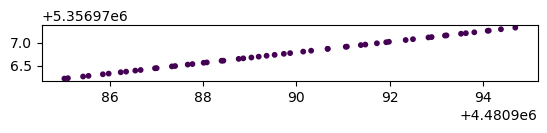

In [436]:
labels = ransac_lines(xyz, threshold=0.05, max_iterations=20)
max_label = labels.max()

x = xyz[:, 0]
y = xyz[:, 1]

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=labels, cmap='viridis', s=10)
# plt.colorbar(sc)
#equal aspect ratio
ax.set_aspect('equal', adjustable='box')


In [437]:
labels[0], labels.max()

(np.int64(0), np.int64(0))

In [438]:
if (active_line.start_fid is not None): print("active line is reversable")

active line is reversable


In [439]:
# If the start point is in a switch, it causes all kinds of problems 
if first_iteration and max_label > 0:
    # Create another line and stop here
    feature.SetField("skip", 1)
    layer.SetFeature(feature)

    print("old", feature.GetFID())

    layer.ResetReading()
    layer.SetAttributeFilter("skip IS NULL")
    feature = layer.GetNextFeature()
    layer.ResetReading()
    layer.SetAttributeFilter(None)
    print("new", feature.GetFID())
    active_line = GrowingLine.from_feature(feature)
    first_iteration = True
    raise StartInSwitchError
first_iteration = False

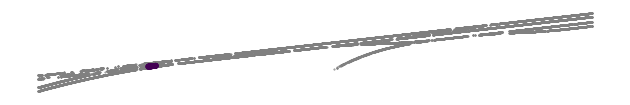

In [440]:
fig, ax = plt.subplots()
ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=0.2)
ax.scatter(x, y, c=labels, cmap='viridis', s=10)
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()
fig.tight_layout()
fig.savefig("current_ransac_lines.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [441]:
remove_points(fids[labels == -1], layer)

In [ ]:
# Check if we reached the end of a switch
if active_line.in_switch() and labels.max() == 0:
    if labels[0] == -1:
        print("Active line ends in switch")
        # idx = active_line.index_closest_point([active_line.switch[0], active_line.switch[1]])
        # closest_point = active_line.points[idx]
        geom = ogr.Geometry(ogr.wkbPoint)
        geom.AddPoint(active_line.head_xyz[0], active_line.head_xyz[1]) 
        add_to_layer(switchlayer, geom)

        new_switches.append(active_line.head_xyz)
        make_cut = True # Reverses head
    else:
        length = np.linalg.norm(active_line.switch[0] - active_line.switch[-1])
        print("Switch line length:", length)
        if length > 5:
            make_cut = True
            print("CUT")

            point = active_line.make_cut()
            geom = ogr.Geometry(ogr.wkbPoint)
            geom.AddPoint(point[0], point[1])
            add_to_layer(switchlayer, geom)
            new_switches.append(point)
        else:
            make_cut = False
            print("No cut, switch line too short")
            active_line.switch = None

else:
    make_cut = False
    for label in range(labels.max()+1):
        cluster = xyz[labels == label]
        if len(cluster) < 2:
            continue

        
        fids_cluster = fids[labels == label]
        directions_cluster = directions[labels == label]
        

        if label == labels[0]:
            # This is the active head 
            pruned, offset = pruned_points(cluster)
            remove_points(fids_cluster[:offset+1], layer)

            new_direction = directions_cluster[offset]
            if active_line.head_direction @ new_direction < 0:
                new_direction = -new_direction

            active_line.head_xyz = pruned[-1]
            active_line.head_direction = new_direction
            active_line.head_fid = fids_cluster[offset]

            if np.array_equal(pruned[0], active_line.points[-1]):
                # Remove the first point if it is already in the line
                pruned = pruned[1:]  
            
            active_line.points.extend(pruned) 
            print(len(pruned), "points added to active line")
        else:
            # This is the other rail in a switch (or false positive)
            active_line.add_switchline(cluster[-1], cluster[0])

    if len(switches) > 0:
        active_line.make_cut(switches)
        make_cut = True



Switch line length: 1.9592341916219473
No cut, switch line too short


In [443]:
print("active line points:", len(active_line.points))
print("in switch:", active_line.in_switch())

active line points: 166
in switch: False


(5356975.469102779, 5356996.1704910025)

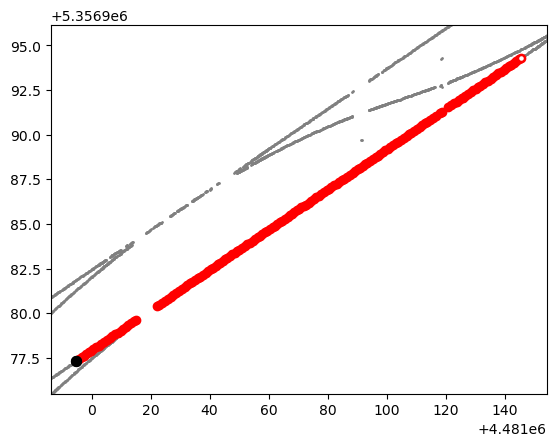

In [444]:
fig, ax = plt.subplots()


active = np.array(active_line.points) 

ax.scatter(active[:, 0], active[:, 1], c='red')
ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')
ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')

if active_line.switch is not None:
    for point in active_line.switch:
        ax.scatter(point[0], point[1], c='blue', s=50)
   
for point in switches:
    ax.scatter(point[0], point[1], c='green', marker='x', s=30)

for point in new_switches:
    ax.scatter(point[0], point[1], c='orange', marker='x', s=30)

if active_line.start_fid is not None:
    ax.scatter(active_line.start_xyz[0], active_line.start_xyz[1], c='white', s=5)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

x_lim = (x_lim[0] - 1, x_lim[1] + 1)
y_lim = (y_lim[0] - 1, y_lim[1] + 1)

ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=1, zorder=0)


# ax.scatter(first_xyz[0], first_xyz[1], c='yellow', s=20)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
#ax.set_aspect('equal', adjustable='box')

In [445]:
if make_cut:
    if not active_line.reverse_head():
        # If we can't reverse the head, we are done
        print("Finished growing line")
        queue.extend(active_line.next_lines)
        print(len(queue), "in queue")
        active_line = queue.popleft()

## STOP HERE

In [446]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
active_line.reverse_head()

In [ ]:
queue.extend(active_line.switch)
print(len(queue))
active_line = queue.popleft()

In [ ]:
geom = active_line.get_linestring()
print(geom.Length())

if geom.Length() > 5:
    add_to_layer(linelayer, geom)


In [ ]:
ds = None

In [ ]:
print(len(active_line.switch))

In [ ]:
active_line.points

In [ ]:
active_line.head_fid

In [ ]:
active_line.head_xyz

In [ ]:
active_line.switch 

In [ ]:
active_line.switch[0].head_fid  

In [ ]:
active_line.switch[1].head_fid  

In [ ]:
foo = np.array(active_line.points)
foo = foo[:,1] 
x = np.arange(len(foo))
fig, ax = plt.subplots()
ax.plot(x, foo)

In [ ]:
fig, ax = plt.subplots()
foo = np.array(active_line.points)
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

foo = np.array(active_line.switch[0].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='r', s=1)

foo = np.array(active_line.switch[1].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='g', s=1)

foo = np.array(active_line.switch[2].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

In [ ]:
remove_points([feature.GetFID()], layer)

In [ ]:
raise StartInSwitchError

StartInSwitchError: Start point is in a switch, prone to bugs.

In [ ]:
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(-122.23, 47.09)

In [ ]:
point.GetPoint() 

(-122.23, 47.09, 0.0)